# Metadata

```
-----------------------------------------
Course:   DS 5001
Module:   12 Lab
Topic:    Classification with Naive Bayes
Author:   R.C. Alvarado
-----------------------------------------
Purpose: We attempt a Naive Bayes classifier for the sentiment of a corpus of wine reviews. We use the score of the review as our sentiment value, assuming that a bad review will have negative sentiment and a good review will have positive sentiment.
```

# Overview

The prediction of the document's label (class) can be viewed as problem of conditional probability:
* $p(c|d) =$ ?
* $p(c|d) = \large\frac{p(c)p(d|c)}{p(d)}$
* $p(c|d) = p(c)p(d|c)$

We use Maximum A Posteriori estimation (MAP) to predict the label:
* $p(c|d) = \underset{C}{\mathrm{argmax}} p(c)p(d|c)$ 

To solve this, we need to estimate the values of the priors $p(c)$ and the likelihoods $p(d|c)$.
* Prior: $p(c)$ the frequency of a given category.
* Likelihood: $p(d|c)$ the frequency of the document for a given category. Remember, these are essentially unigram language models for each label. They are similar to topics in this sense.

Note that $d$ is a sequence of words $w_{1}^{N}$, which means we apply the independence assumption to avoid the chain rule:
* $p(d|c) = p(w_{1}^{N}|c) = p(w_{1}|c)p(w_{2},w_{1}|c) ... $
* $p(d|c) = \prod{p(w_{i}|c}) = \sum{log(p(w_{i}|c))}$

So, we get:
* $p(c|d) = \underset{C}{\mathrm{argmax}} p(c)\sum{log(p(w_{i}|c))}$ 

We can estimate the priors and the likelihoods using Maximum Likelihood Estimation (MLE) from data that gives the joint distribution of documents and labels, where documents are represented as bags of words. This joint distribution is just the TOKEN table with the label from the LIB table joined to it.
* $(d,w,c)$

**NOTES**
* Both forms of estimation used are optimization methods. 
> **Optimization** is a general term for finding the maximum, or minimum, of some function. **Estimation** is a statistical term for finding some estimate of unknown parameter, given some data. This can be done using optimization methods, e.g. by maximizing the likelihood function, or minimizing a loss function. So optimization is broader, as you can use it without data, just by finding the maximum of some abstract function, while estimation has a clear statistical scope. Optimization can be used for estimation, but you can also use methods not based on optimization for estimation.

# Set Up

In [1]:
data_home = '../data'
local_lib = '../lib'

In [2]:
n_sets = 4 # We want 4 so we can use 3 for training, 1 for testing.
smooth_alpha = 1 
# agg_method = 'sum'
agg_method = 'count'
stopwords = set('and the a of this with is it in to on but an for are has that from not through'.split())

In [3]:
import pandas as pd
import numpy as np
from numpy import log2 as log
from numpy import exp2 as exp
from numpy.random import randint
import nltk
import matplotlib.pyplot as plt

# Preparation

## Get Data

In [4]:
docs = pd.read_csv(f'{data_home}/winereviews/winereviews.csv', index_col='doc_id')

In [5]:
docs.head()

,doc_content,points
doc_id,,
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


## Explore points feature

**Out of curiosity, see if review length correlates with points.**

In [6]:
docs['doc_len'] = docs.doc_content.str.len()

In [7]:
# docs.doc_len.value_counts().sort_index().plot() #hist()

In [8]:
# docs.doc_len.plot.box()

In [9]:
round(docs.points.corr(docs.doc_len), 2)

0.56

<AxesSubplot:>

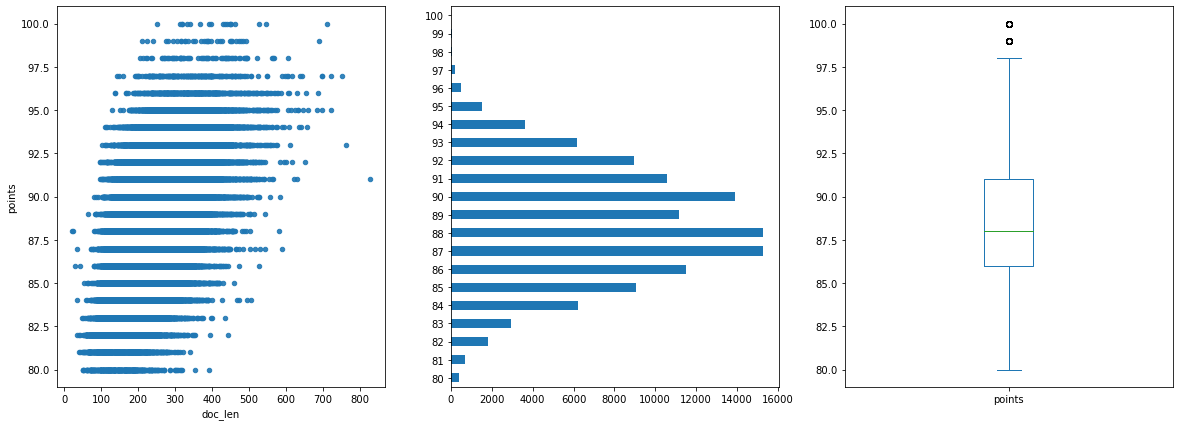

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,7), sharey=False)
docs.plot.scatter('doc_len','points', alpha=.9, ax=axes[0]);
docs.points.value_counts().sort_index().plot.barh(rot=0, ax=axes[1]);
docs.points.plot.box(ax=axes[2])

## Convert points to labels

Keep only reviews with high and low ratings. We use $93$ and $87$ by convention.

In [11]:
docs.loc[docs.points >= 93, 'doc_label'] = 'P'
docs.loc[docs.points < 87, 'doc_label'] = 'N'

In [12]:
docs.sample(10)

,doc_content,points,doc_len,doc_label
doc_id,,,,
59286,"This is a modern-styled, young Priorat with dr...",94,321,P
48354,"Exuberantly perfumed with notes of honey, tang...",82,197,N
47481,Cantina del Pino makes some of the finest Barb...,91,223,NaN
95441,"This perfumed, smoky wine is gently wood aged ...",94,222,P
69780,Docile aromas of apricot and peach linger unde...,86,281,N
70680,"It opens with scents of plum, red berries, sag...",90,265,NaN
48513,Forest fruits and warming spices lead this ele...,92,268,NaN
33979,"Lime, fig and taffy flavors mark this successf...",85,256,N
54781,"Delicious in cola spice and earthy tannins, th...",92,244,NaN


## Balance Labels

Note the imbalance in number of documents associated with each label.

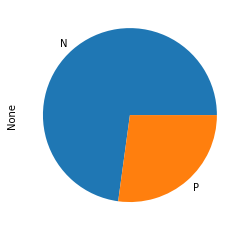

In [13]:
docs.value_counts('doc_label').plot.pie();

In [14]:
CLASS = docs.value_counts('doc_label').to_frame('n')

In [15]:
CLASS

,n
doc_label,
N,32679
P,12184


We use $12000$ as our common value.

In [16]:
DOCS = docs.groupby('doc_label').sample(CLASS.n.min())

In [17]:
DOCS.sample(10)

,doc_content,points,doc_len,doc_label
doc_id,,,,
86672,This is an easy Pinot Grigio that can be emplo...,85,179,N
124213,The third reserve by this producer made of thi...,93,280,P
73414,"Fresh and floral, this informal wine delivers ...",86,234,N
63781,"Despite it's finely filigreed mouthfeel, this ...",94,345,P
15542,"Yeasty freshness swings along with the citrus,...",94,289,P
45818,"The vintage was very kind to Chardonnay, and t...",94,349,P
60026,Austin Hope's latest releases are all about po...,95,395,P
35078,From the estate's Alfio Moriconi Selection ran...,83,189,N
27560,The spicy nose already signals joy: Bosc pear ...,94,366,P


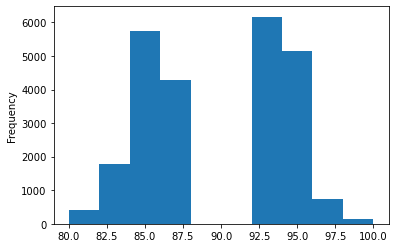

In [18]:
DOCS.points.plot.hist();

**Average `doc_len` per group**

NOTE: Good reviews are few and long, bad reviews are many and short.

In [19]:
CLASS['mean_len'] = DOCS.groupby('doc_label').doc_len.mean()

In [20]:
CLASS.mean_len.round()

doc_label
N    199.0
P    313.0
Name: mean_len, dtype: float64

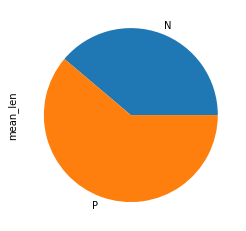

In [21]:
CLASS.mean_len.plot.pie();

## Divide docs into train and test sets

**Assign random numbers to docs**

In [22]:
DOCS['set'] = randint(0, n_sets, len(DOCS.index))

In [23]:
DOCS.head()

,doc_content,points,doc_len,doc_label,set
doc_id,,,,,
120355,"Dry and somewhat heavy, it has cherry jam and ...",84,58,N,3
68869,While there is a herbal character to this wine...,86,201,N,1
102168,"This is a muddled, roughly textured effort, ri...",84,104,N,2
41000,"Nearing greenish-yellow in the glass, this win...",86,218,N,0
31543,"Dark, gummy and full of heavily applied green ...",84,274,N,3


**Split docs by assigned number**

In [24]:
DOCS.loc[DOCS.set != 0, 'group'] = 'train'
DOCS.loc[DOCS.set == 0, 'group'] = 'test'

In [25]:
train_idx = DOCS[DOCS.group == 'train'].index
test_idx = DOCS[DOCS.group == 'test'].index

In [26]:
DOCS

,doc_content,points,doc_len,doc_label,set,group
doc_id,,,,,,
120355,"Dry and somewhat heavy, it has cherry jam and ...",84,58,N,3,train
68869,While there is a herbal character to this wine...,86,201,N,1,train
102168,"This is a muddled, roughly textured effort, ri...",84,104,N,2,train
41000,"Nearing greenish-yellow in the glass, this win...",86,218,N,0,test
31543,"Dark, gummy and full of heavily applied green ...",84,274,N,3,train
...,...,...,...,...,...,...
102248,"This wine is überaromatic, with notes of raspb...",93,245,P,2,train
100165,"Toasty, dense, dark and complex, this is suffu...",95,354,P,1,train
3647,"This vineyard, the “way to the church,” gives ...",93,191,P,2,train


In [27]:
round(DOCS.value_counts('group')[0] / DOCS.value_counts('group')[1], 2)

2.98

# Tokenize (Vectorize)

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

## Training Data

In [29]:
count_engine_train = CountVectorizer(binary=True, max_df=.9, min_df=10, stop_words='english', max_features=4000)
count_matrix_train = count_engine_train.fit_transform(DOCS.loc[train_idx].doc_content)
TRAIN = pd.DataFrame(count_matrix_train.toarray(), index=train_idx, columns=count_engine_train.get_feature_names_out()).sort_index()

In [30]:
TRAIN

,000,04,05,06,07,08,09,10,100,11,...,zero,zest,zestiness,zesty,zin,zinfandel,zing,zingy,zip,zippy
doc_id,,,,,,,,,,,,,,,,,,,,,
30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
129842,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Extract VOCAB

**Note that we only use the vocabulary of the training data.**

In [31]:
VOCAB = TRAIN.sum().to_frame('n')
VOCAB.index.name = 'term_str'

In [32]:
# VOCAB

## Testing Data

**Note that we use the vocabulary from the training set.**

In [33]:
count_engine_test = CountVectorizer(binary=True, max_df=.9, min_df=10, stop_words='english', max_features=4000, vocabulary=VOCAB.index)
count_matrix_test = count_engine_test.fit_transform(DOCS.loc[test_idx].doc_content)
TEST = pd.DataFrame(count_matrix_test.toarray(), index=test_idx, columns=count_engine_test.get_feature_names_out()).sort_index()

In [34]:
TEST

,000,04,05,06,07,08,09,10,100,11,...,zero,zest,zestiness,zesty,zin,zinfandel,zing,zingy,zip,zippy
doc_id,,,,,,,,,,,,,,,,,,,,,
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129679,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training

## Estimate priors $p(c)$

$$
\hat{P}(c) = \dfrac{N_{c}}{N_{d}}
$$

In [35]:
Nc = TRAIN.join(DOCS.doc_label).groupby('doc_label').sum().T.sum()

In [36]:
Nd = TRAIN.sum().sum()

In [37]:
PRIORS = Nc / Nd

In [38]:
np.round(PRIORS, 3)

doc_label
N    0.394
P    0.606
dtype: float64

## Estimate likelihoods $p(w|c)$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)}{\sum_{w \in V} count(w,c)}
$$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)+1}{\sum_{w \in V} (count(w,c)+1)} = \dfrac{count(w_i,c)+1}{(\sum_{w \in V} count(w,c))+|V|} 
$$



Now we compute the probability of a token given the label. This will in effect product two language models, one for each label. Key idea = **the likelihoods are language models** (see Pearl for interpretation of likelihoods).

In [39]:
LIKELIHOODS = TRAIN.join(DOCS.doc_label, how='left').groupby('doc_label').sum()
LIKELIHOODS.columns.name = 'term_str'
LIKELIHOODS = LIKELIHOODS + 1 # Smoothing
LIKELIHOODS = (LIKELIHOODS.T / LIKELIHOODS.T.sum())

In [40]:
LIKELIHOODS.sample(10).style.background_gradient(axis=None, cmap='GnBu')

doc_label,N,P
term_str,,
utter,0.000006,0.000070
jerky,0.000024,0.000066
darkly,0.000047,0.000078
combination,0.000190,0.000287
true,0.000231,0.000264
brimming,0.000047,0.000082
mingle,0.000142,0.000198
mineral,0.001252,0.002539
abundant,0.000089,0.000074


**Convert likelihoods to logs**

# Testing

## Estimate posteriors $p(c|w)$

$$
c_{NB} = \arg\max \log{P(c)} + \sum_{id=1}^{id_{max}} \log{P(token_{id}|c)}
$$

In [41]:
%%time
POSTERIORS = pd.concat([(TEST * np.log(LIKELIHOODS[cat])).sum(1) + np.log(PRIORS[cat]) for cat in CLASS.index], axis=1, keys=CLASS.index)\
    .idxmax(1)\
    .to_frame('prediction')\
    .join(DOCS)

CPU times: user 277 ms, sys: 456 ms, total: 732 ms
Wall time: 214 ms


# Evaluation

In [42]:
POSTERIORS['result'] = POSTERIORS.prediction == POSTERIORS.doc_label
POSTERIORS['result_type'] = POSTERIORS.result.astype('str').str[0] + POSTERIORS.prediction

## Show T & F counts

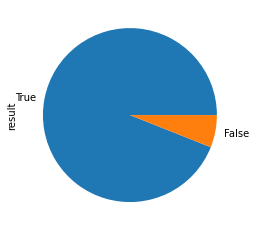

In [43]:
POSTERIORS.result.value_counts().plot.pie();

## Show TP, TN, FP, FN counts

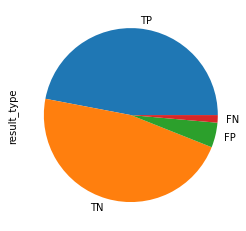

In [44]:
POSTERIORS.result_type.value_counts().plot.pie();

## Where the errors are

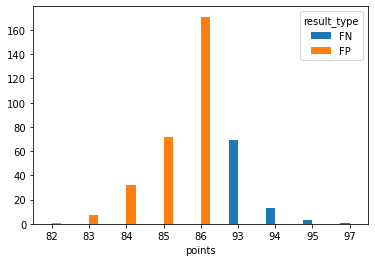

In [45]:
POSTERIORS.query("result == False").value_counts(['points','result_type']).sort_index().unstack().plot.bar(rot=0);

## Create confusion matrix

In [46]:
CM = POSTERIORS.reset_index().groupby(['prediction','doc_label']).doc_id.count().unstack().fillna(0)

In [47]:
CM.columns.name = 'actual'

In [48]:
CM

actual,N,P
prediction,,
N,2879,86
P,283,2880


## Show scores

In [49]:
def show_results(M):
    
    R = M.groupby('result_type').result_type.count().T
    
    print(R)
    print()

    # TP:  hits
    # FP:  Type I errors; false alarms
    # TN:  correct rejections
    # FN:  Type  II errors; misses
    # ACC: Accuracy
    # TPR: True Positive Rate, Recall, Sensitivity
    # TNR: True Negative Rate, Specificity
    # PPV: Positive Predictive Value, Precision
    # BA:  Balanced Accuracy
    # F1:  F-score where F = 1

    T = R.TP + R.TN
    F = R.FP + R.FN
    ALL =  T + F

    ACC = T / ALL
    TPR = R.TP / (R.TP + R.FN)
    TNR = R.TN / (R.TN + R.FP)
    PPV = R.TP / (R.TP + R.FP)
    BA = (TNR + TPR) / 2
    F1 = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN)

    assert ALL == R.sum()

    print('TPR:', round(TPR, 2), '(sensitivity)')
    print('TNR:', round(TNR, 2), '(specificity)')
    print('F1: ', round(F1, 2), '<-- GRADE')
    print('PPV:', round(PPV, 2),  '(precision)')
    print('ACC:', round(ACC, 2), '(accuracy)')        

In [50]:
show_results(POSTERIORS)

result_type
FN      86
FP     283
TN    2879
TP    2880
Name: result_type, dtype: int64

TPR: 0.97 (sensitivity)
TNR: 0.91 (specificity)
F1:  0.94 <-- GRADE
PPV: 0.91 (precision)
ACC: 0.94 (accuracy)


# Exploration

## Likelihoods as Sentiment Lexicon 

Remember, the likelihoods are language models.

**We make up a way to compute sentiment valence and polarity**

In [51]:
SALEX = (np.sign(LIKELIHOODS['P'] - LIKELIHOODS['N'])).to_frame('polarity')
SALEX['valence'] = (LIKELIHOODS['P'] - LIKELIHOODS['N'])

In [52]:
SALEX

,polarity,valence
term_str,,
000,-1.0,-0.000082
04,1.0,0.000011
05,1.0,0.000040
06,1.0,0.000021
07,1.0,0.000025
...,...,...
zinfandel,-1.0,-0.000537
zing,-1.0,-0.000008
zingy,-1.0,-0.000025


**Ratio of positive to negative terms**

This may be a function of doc_length.

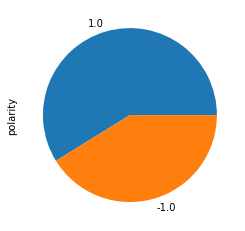

In [53]:
SALEX.polarity.value_counts().plot(kind='pie');

## Compare Positive to Negative Words

### Top positives

In [54]:
SALEX.sort_values('valence', ascending=False).head(10)

,polarity,valence
term_str,,
black,1.0,0.005404
rich,1.0,0.005086
years,1.0,0.004920
concentrated,1.0,0.003627
vineyard,1.0,0.003569
dark,1.0,0.003460
complex,1.0,0.003346
long,1.0,0.003309
tannins,1.0,0.003218


### Top negatives

In [55]:
SALEX.sort_values('valence', ascending=True).head(10)

,polarity,valence
term_str,,
flavors,-1.0,-0.014498
aromas,-1.0,-0.008323
finish,-1.0,-0.007311
light,-1.0,-0.005338
soft,-1.0,-0.005276
simple,-1.0,-0.004562
green,-1.0,-0.004150
sweet,-1.0,-0.004102
fruity,-1.0,-0.004003


### Bar Chart

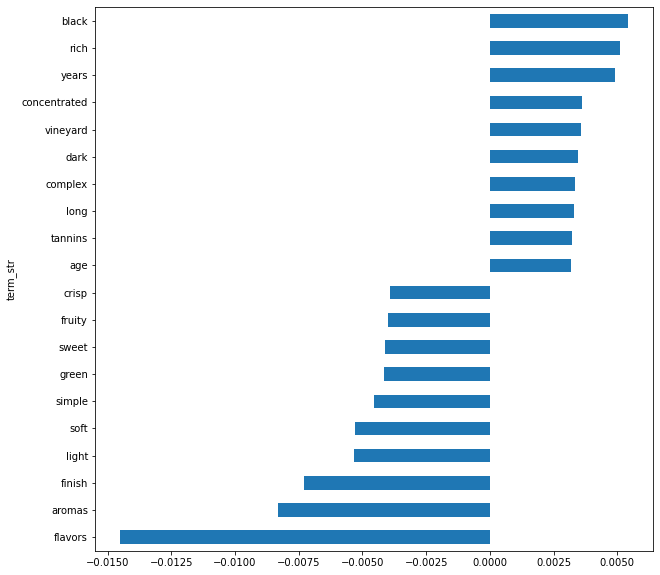

In [56]:
wpos = SALEX.valence.sort_values(ascending=False).head(10)
wneg = SALEX.valence.sort_values(ascending=False).tail(10)
pd.concat([wpos,wneg]).sort_values().plot.barh(figsize=(10,10));

# Save

In [57]:
DOCS.to_csv(f"{data_home}/winereviews/winereviews-NB_DOCS.csv", index=True)
TRAIN.to_csv(f"{data_home}/winereviews/winereviews-NB_TRAIN.csv", index=True)
TEST.to_csv(f"{data_home}/winereviews/winereviews-NB_TEST.csv", index=True)
VOCAB.to_csv(f"{data_home}/winereviews/winereviews-NB_VOCAB.csv", index=True)
PRIORS.to_csv(f"{data_home}/winereviews/winereviews-NB_PRIORS.csv", index=True)
LIKELIHOODS.to_csv(f"{data_home}/winereviews/winereviews-NB_LIKELIHOODS.csv", index=True)
POSTERIORS.to_csv(f"{data_home}/winereviews/winereviews-NB_POSTERIORS.csv", index=True)
SALEX.to_csv(f"{data_home}/winereviews/winereviews-NB_SALEX.csv", index=True)

# Appendix: Convert Points to Grades

You might do this if you wanted a multinomial model that distinguished betwen A+, A, A-, et.c

In [58]:
def convert_num_to_grade(num:int):
    letter = ''

    if num < 90:
        letter = 'B'
    else:
        letter = 'A'
        
    if num % 10 < 3:
        # letter += '-'
        letter += '0'
    elif num % 10 > 6:
        # letter += '+'
        letter += '2'
    else:
        # letter += ''
        letter += '1'
        
    return letter

In [59]:
def test_convert_num_to_grade():
    for num in range(80,101):
        let = convert_num_to_grade(num)
        print(num, let)

In [60]:
test_convert_num_to_grade()

80 B0
81 B0
82 B0
83 B1
84 B1
85 B1
86 B1
87 B2
88 B2
89 B2
90 A0
91 A0
92 A0
93 A1
94 A1
95 A1
96 A1
97 A2
98 A2
99 A2
100 A0


In [61]:
docs['grade'] = docs.points.apply(convert_num_to_grade)

In [62]:
docs

,doc_content,points,doc_len,doc_label,grade
doc_id,,,,,
0,"Aromas include tropical fruit, broom, brimston...",87,172,NaN,B2
1,"This is ripe and fruity, a wine that is smooth...",87,227,NaN,B2
2,"Tart and snappy, the flavors of lime flesh and...",87,186,NaN,B2
3,"Pineapple rind, lemon pith and orange blossom ...",87,199,NaN,B2
4,"Much like the regular bottling from 2012, this...",87,249,NaN,B2
...,...,...,...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,90,227,NaN,A0
129967,Citation is given as much as a decade of bottl...,90,233,NaN,A0
129968,Well-drained gravel soil gives this wine its c...,90,225,NaN,A0


# Appendix: Relation to Data Model

**Table Families**:
* DOC: TEST, TRAIN, POSTERIORS
* CLASS: PRIORS
* VOCAB: LIKELIHOODS, SALEX

## Create the Document-Class table that has maximized

This is like the THETA table in a topic model.

In [97]:
Q = pd.concat([(TEST * np.log(LIKELIHOODS[cat])) for cat in CLASS.index], axis=1, keys=CLASS.index)

In [98]:
Q

doc_label    N                                                     ...    P  \
           000   04   05   06   07         08   09   10  100   11  ... zero   
doc_id                                                             ...        
31        -0.0 -0.0 -0.0 -0.0 -0.0  -0.000000 -0.0 -0.0 -0.0 -0.0  ... -0.0   
35        -0.0 -0.0 -0.0 -0.0 -0.0  -0.000000 -0.0 -0.0 -0.0 -0.0  ... -0.0   
44        -0.0 -0.0 -0.0 -0.0 -0.0  -0.000000 -0.0 -0.0 -0.0 -0.0  ... -0.0   
51        -0.0 -0.0 -0.0 -0.0 -0.0 -10.648474 -0.0 -0.0 -0.0 -0.0  ... -0.0   
66        -0.0 -0.0 -0.0 -0.0 -0.0  -0.000000 -0.0 -0.0 -0.0 -0.0  ... -0.0   
...        ...  ...  ...  ...  ...        ...  ...  ...  ...  ...  ...  ...   
129679    -0.0 -0.0 -0.0 -0.0 -0.0  -0.000000 -0.0 -0.0 -0.0 -0.0  ... -0.0   
129680    -0.0 -0.0 -0.0 -0.0 -0.0  -0.000000 -0.0 -0.0 -0.0 -0.0  ... -0.0   
129681    -0.0 -0.0 -0.0 -0.0 -0.0  -0.000000 -0.0 -0.0 -0.0 -0.0  ... -0.0   
129833    -0.0 -0.0 -0.0 -0.0 -0.0  -0.000000 -0.0 -0.0 -0.0 -0.0  ... -0.0   
129848    -0.0 -0.0 -0.0 -0.0 -0.0  -0.000000 -0.0 -0.0 -0.0 -0.0  ... -0.0   

doc_label                                                            
          zest zestiness zesty  zin zinfandel zing zingy  zip zippy  
doc_id                                                               
31        -0.0      -0.0  -0.0 -0.0      -0.0 -0.0  -0.0 -0.0  -0.0  
35        -0.0      -0.0  -0.0 -0.0      -0.0 -0.0  -0.0 -0.0  -0.0  
44        -0.0      -0.0  -0.0 -0.0      -0.0 -0.0  -0.0 -0.0  -0.0  
51        -0.0      -0.0  -0.0 -0.0      -0.0 -0.0  -0.0 -0.0  -0.0  
66        -0.0      -0.0  -0.0 -0.0      -0.0 -0.0  -0.0 -0.0  -0.0  
...        ...       ...   ...  ...       ...  ...   ...  ...   ...  
129679    -0.0      -0.0  -0.0 -0.0      -0.0 -0.0  -0.0 -0.0  -0.0  
129680    -0.0      -0.0  -0.0 -0.0      -0.0 -0.0  -0.0 -0.0  -0.0  
129681    -0.0      -0.0  -0.0 -0.0      -0.0 -0.0  -0.0 -0.0  -0.0  
129833    -0.0      -0.0  -0.0 -0.0      -0.0 -0.0  -0.0 -0.0  -0.0  
129848    -0.0      -0.0  -0.0 -0.0      -0.0 -0.0  -0.0 -0.0  -0.0  

[6128 rows x 7166 columns]

In [99]:
Q.N

,000,04,05,06,07,08,09,10,100,11,...,zero,zest,zestiness,zesty,zin,zinfandel,zing,zingy,zip,zippy
doc_id,,,,,,,,,,,,,,,,,,,,,
31,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
35,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
44,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
51,-0.0,-0.0,-0.0,-0.0,-0.0,-10.648474,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
66,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129679,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
129680,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
129681,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [101]:
Q.N.sum()

000          -88.158924
04           -51.215044
05           -98.425403
06           -20.177716
07           -32.808468
                ...    
zinfandel   -283.965941
zing         -81.944070
zingy        -85.948754
zip          -69.687286
zippy       -135.585539
Length: 3583, dtype: float64

In [102]:
Q.P

,000,04,05,06,07,08,09,10,100,11,...,zero,zest,zestiness,zesty,zin,zinfandel,zing,zingy,zip,zippy
doc_id,,,,,,,,,,,,,,,,,,,,,
31,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
35,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
44,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
51,-0.0,-0.0,-0.0,-0.0,-0.0,-10.37959,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
66,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129679,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
129680,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
129681,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00000,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [103]:
Q.P.sum(1)

doc_id
31       -136.443840
35       -136.749139
44        -94.750211
51       -206.306841
66        -96.398667
             ...    
129679   -200.811892
129680   -113.425068
129681   -161.849192
129833   -160.298634
129848   -172.941120
Length: 6128, dtype: float64

In [104]:
import plotly_express as px

In [105]:
X = Q.T.groupby('doc_label').sum().T.join(DOCS).join(POSTERIORS[['prediction','result','result_type']])

In [106]:
X

,N,P,doc_content,points,doc_len,doc_label,set,group,prediction,result,result_type
doc_id,,,,,,,,,,,
31,-125.552152,-136.443840,Merlot and Nero d'Avola form the base for this...,86,175,N,0,test,N,True,TN
35,-131.195538,-136.749139,As with many of the Erath 2010 vineyard design...,86,242,N,0,test,N,True,TN
44,-88.972319,-94.750211,A berry aroma comes with cola and herb notes. ...,86,141,N,0,test,N,True,TN
51,-197.391277,-206.306841,This is much different than Casa Silva's 2009 ...,85,305,N,0,test,N,True,TN
66,-87.090318,-96.398667,"This soft, rounded wine is ripe with generous ...",86,149,N,0,test,N,True,TN
...,...,...,...,...,...,...,...,...,...,...,...
129679,-214.594450,-200.811892,From a ranch planted originally in 1926 this i...,93,307,P,0,test,P,True,TP
129680,-129.920567,-113.425068,Old vines in a field blend give a rich structu...,93,242,P,0,test,P,True,TP
129681,-181.483515,-161.849192,"Ripe black-skinned berry, violet, leather and ...",93,227,P,0,test,P,True,TP


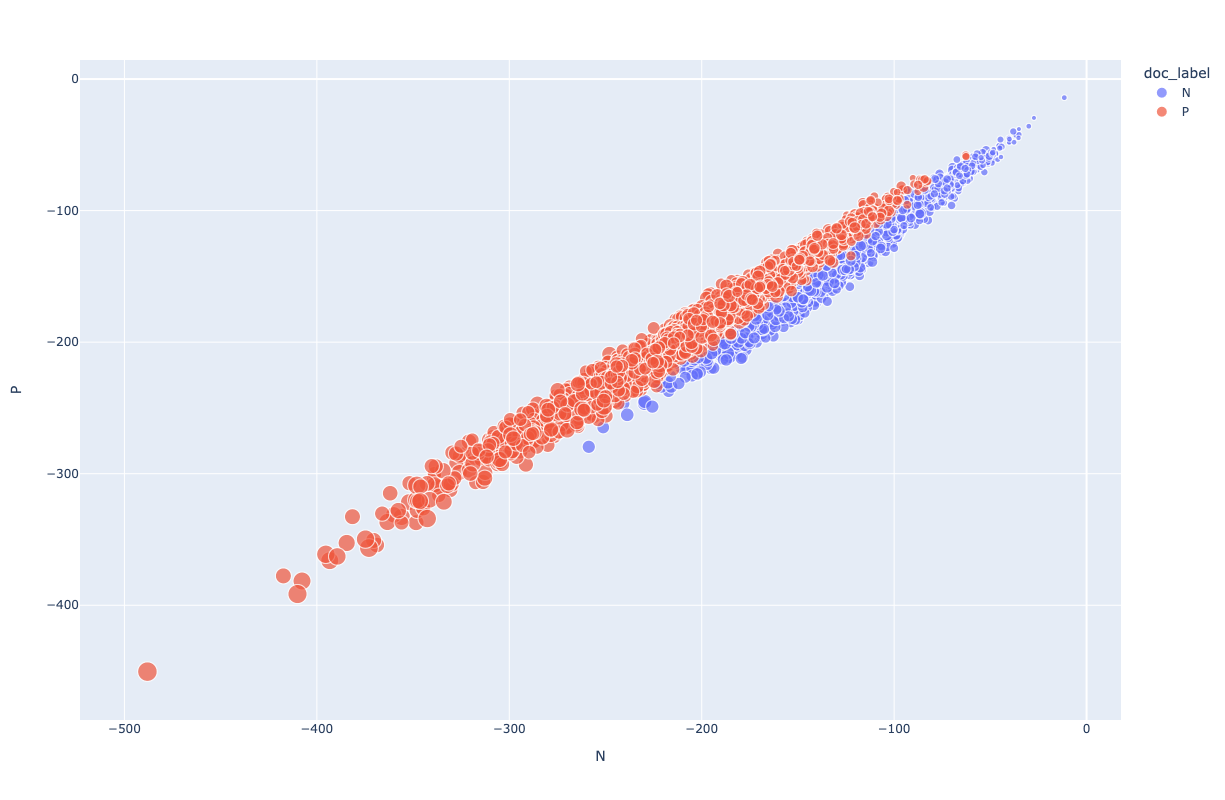

In [110]:
px.scatter(X, 'N','P', color='doc_label', hover_name='points', size='doc_len',
           height=800, width=1000)

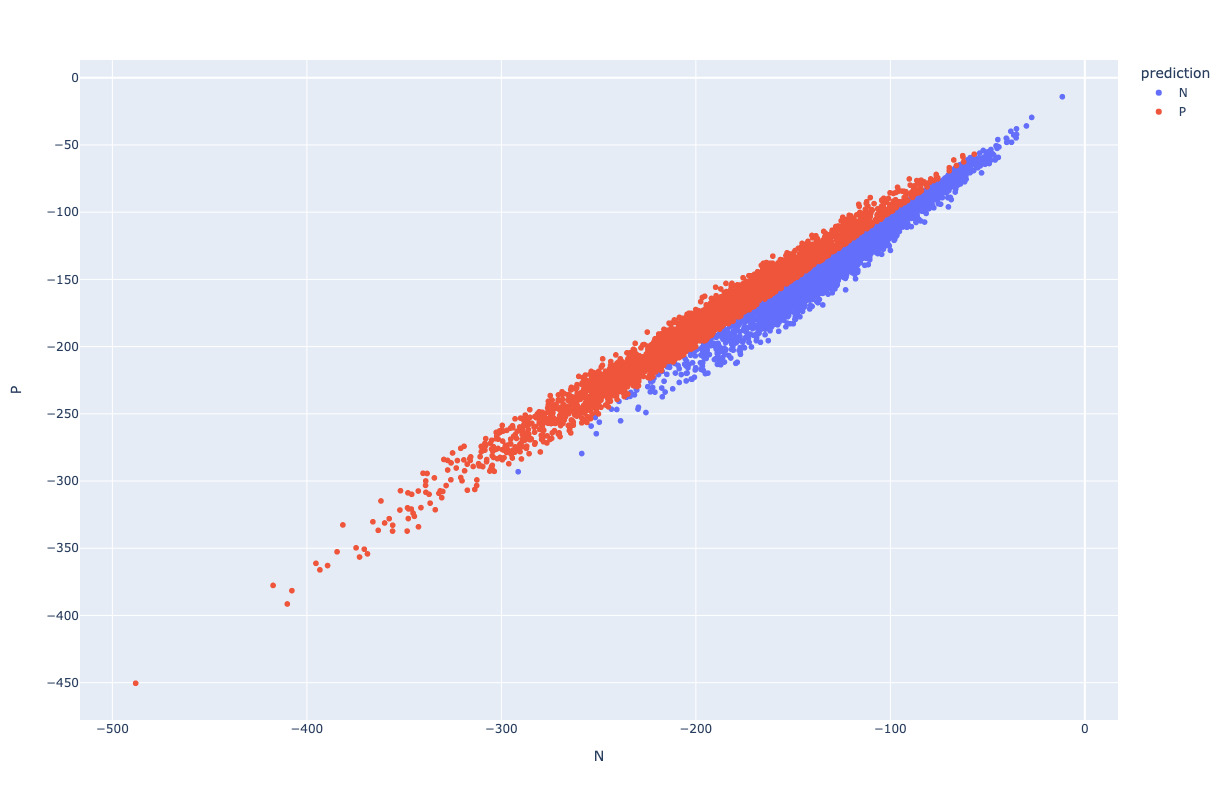

In [119]:
px.scatter(X, 'N','P', color='prediction', hover_name='points', height=800, width=1000)

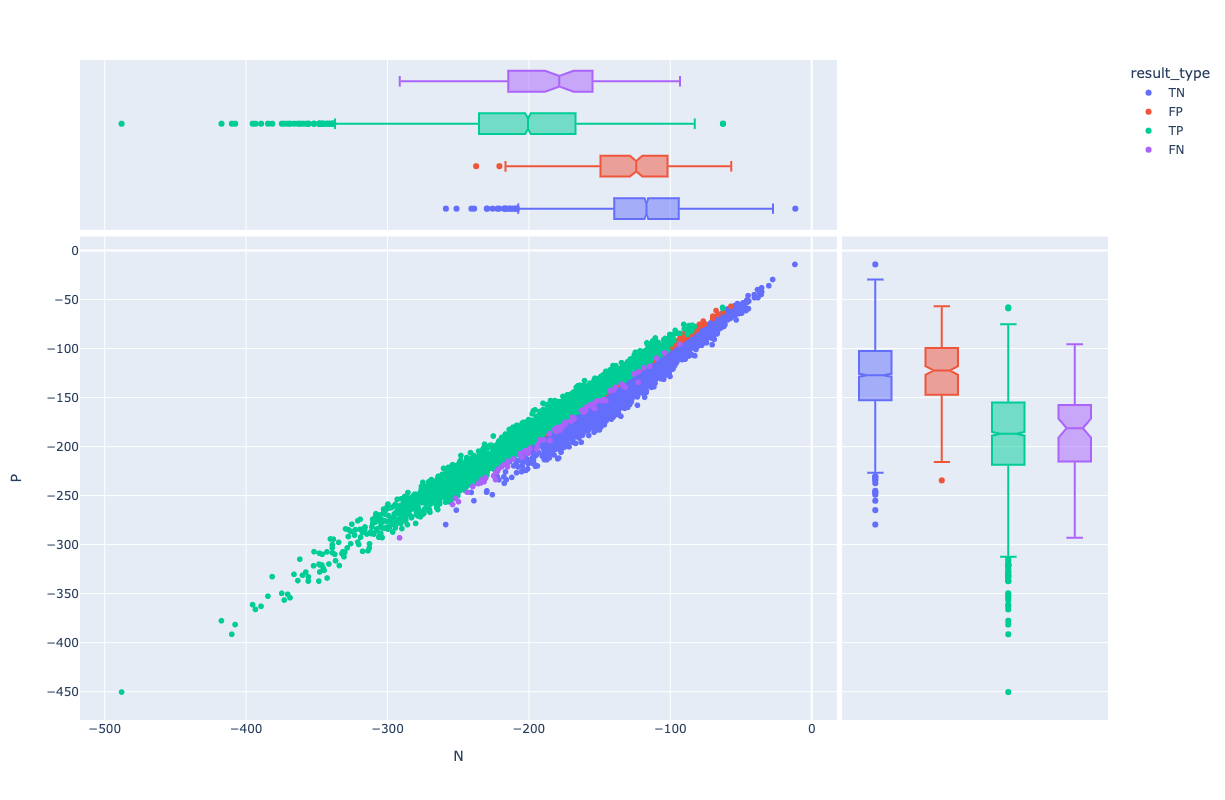

In [120]:
px.scatter(X, 'N','P', color='result_type', hover_name='points', height=800, width=1000, marginal_x='box', marginal_y='box')